# Crop GOES to VIIRS footprint

**Name:** Asaf Vanunu  
**Date:** August 1, 2024  
**step:** 2

## Description
In this script we will crop GOES images into VIIRS footprint also include cases where serveral VIIRS images match a single GOES image in time


* import libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import GOES_VIIRS_tools
from datetime import datetime, timedelta, time
import geopandas as gpd
import rioxarray
from rasterio.plot import show
from functools import reduce

* First we will have to open the VIIRS point shapefile that we generated in the previous step

In [2]:
VIIRS_pnt_dir = "F:\\VIIRS_data\\VIIRS_pnt_shp\\VIIRS_pnt.shp"
VIIRS_pnt = gpd.read_file(VIIRS_pnt_dir)

* Now we will create the GOES fire product list

In [3]:
## Create a GOES fp list
GOES_fp_path = "F:\\Project_data2\\goes_data_false_alarm_cal\\fire_product_out"
GOES_fp_list = [os.path.join(GOES_fp_path, fp) for fp in os.listdir(GOES_fp_path)]
print(f"The length of GOES_fp_list is {len(GOES_fp_list)}")

The length of GOES_fp_list is 42446


* Now we will take the months that we have VIIRS images from so we can filter the GOES images

In [4]:
uniqe_VIIRS_date_list = np.unique(VIIRS_pnt['DATE']) ## Get the unique date list
## Convert the date list to datetime format
uniqe_VIIRS_date_list_time_format = [datetime.strptime(date, "%Y-%m-%d") for date in uniqe_VIIRS_date_list]
## take only unique months
uniqe_VIIRS_month_list = np.unique([date.month for date in uniqe_VIIRS_date_list_time_format])

print(f"Here are the uniqe VIIRS months {uniqe_VIIRS_month_list}")

Here are the uniqe VIIRS months [7 8 9]


* Now we can filter the GOES images to the months that we have VIIRS images

In [5]:
filtered_GOES_fp_list = [] ## Create an empty list to store the filtered GOES file paths
for goes_fp in GOES_fp_list: ## Loop through the GOES file paths
    ## Get the date of the GOES file
    goes_date = GOES_VIIRS_tools.get_time_from_goes(file_name=goes_fp, form="time",
                                                    VIIRS_time="N", NetCDF="N")
    goes_month = goes_date.month ## Get the month of the GOES file
    
    if np.isin(goes_month, uniqe_VIIRS_month_list): ## Check if the month of the GOES file is in the VIIRS month list
        filtered_GOES_fp_list.append(goes_fp) ## If it is, append the GOES file path to the filtered list

print(f"The length of the filtered GOES file list is {len(filtered_GOES_fp_list)}")

The length of the filtered GOES file list is 24092


* Now we will create a matching list of VIIRS and GOES images

In [6]:
## Create a list of matching GOES and VIIRS files
df_list = [] ## Create an empty list to store the dataframes
for i in range(len(filtered_GOES_fp_list)): ## Loop through the GOES files
    ## Compare the GOES and VIIRS files
    df = GOES_VIIRS_tools.compare_GOES_VIIRS_image_time(GOES_fp_path=filtered_GOES_fp_list[i],
                                                        VIIRS_points=VIIRS_pnt, time_delta=5)
    print("{}% of the data is done".format(round(i/len(filtered_GOES_fp_list) * 100, 2)))
    if len(df)>0: ## If there are any matching files
        df_list.append(df) ## Append the dataframe to the list
        print("{} intersect GOES".format(i)) ## Print the number of intersecting files

0.0% of the data is done
0.0% of the data is done
0.01% of the data is done
0.01% of the data is done
0.02% of the data is done
0.02% of the data is done
0.02% of the data is done
0.03% of the data is done
0.03% of the data is done
0.04% of the data is done
0.04% of the data is done
0.05% of the data is done
0.05% of the data is done
0.05% of the data is done
0.06% of the data is done
0.06% of the data is done
0.07% of the data is done
0.07% of the data is done
0.07% of the data is done
0.08% of the data is done
0.08% of the data is done
0.09% of the data is done
0.09% of the data is done
0.1% of the data is done
0.1% of the data is done
0.1% of the data is done
0.11% of the data is done
0.11% of the data is done
0.12% of the data is done
0.12% of the data is done
0.12% of the data is done
0.13% of the data is done
0.13% of the data is done
0.14% of the data is done
0.14% of the data is done
0.15% of the data is done
0.15% of the data is done
0.15% of the data is done
0.16% of the data

In [7]:
## Concat
matching_df = pd.concat(df_list)
print(f"The length of the matching_df is {len(matching_df)}")
matching_df[:5]

The length of the matching_df is 601


,GOES_file,VIIRS_fire_file,VIIRS_GEO_file
0,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022182.0906.001.2022183034226.nc,VNP03IMG.A2022182.0906.002.2022182155401.nc
0,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022182.0906.001.2022183034226.nc,VNP03IMG.A2022182.0906.002.2022182155401.nc
1,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022182.0912.001.2022183034226.nc,VNP03IMG.A2022182.0912.002.2022182155358.nc
0,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022182.0912.001.2022183034226.nc,VNP03IMG.A2022182.0912.002.2022182155358.nc
0,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022182.0912.001.2022183034226.nc,VNP03IMG.A2022182.0912.002.2022182155358.nc


* Now we will create a matching GOES and VIIRS file list where there was no fire in the VIIRS pnt file

* Now we will take unique files so we won't have duplicates

In [8]:
VIIRS_unique_fire_list = np.unique(VIIRS_pnt["Fire_file"])
print(f"The length of the VIIRS_unique_fire_list is {len(VIIRS_unique_fire_list)}")
VIIRS_unique_fire_list[:5]

The length of the VIIRS_unique_fire_list is 339


array(['VNP14IMG.A2022182.0906.001.2022183034226.nc',
       'VNP14IMG.A2022182.0912.001.2022183034226.nc',
       'VNP14IMG.A2022182.1048.001.2022183043359.nc',
       'VNP14IMG.A2022182.2030.001.2022183105210.nc',
       'VNP14IMG.A2022182.2212.001.2022183113626.nc'], dtype=object)

* Now we will create a list of all the VIIRS fire product images

In [9]:
## Take all files
VIIRS_path = "F:\\VIIRS_data\\VIIRS_fire" ## Path to the VIIRS fire files
## Create a list of all VIIRS fire files
all_VIIRS_files = [os.path.join(VIIRS_path, VIIRS) for VIIRS in os.listdir(VIIRS_path) if VIIRS.endswith("nc")]
all_VIIRS_files = np.array(all_VIIRS_files) ## Convert to a numpy array
## create a full path for the unique fire files
VIIRS_unique_full_path = [os.path.join(VIIRS_path, v) for v in VIIRS_unique_fire_list]

In [10]:
print(f"""There are {len(VIIRS_unique_fire_list)} unique VIIRS files in the shapefile and
    {len(all_VIIRS_files)} total VIIRS files in the dataset""")

There are 339 unique VIIRS files in the shapefile and
    651 total VIIRS files in the dataset


In [11]:
## Take all files without fires in the shapefile
## Take the VIIRS images that are not in the shapefile
con_VIIRS = ~np.isin(all_VIIRS_files, VIIRS_unique_full_path) 
no_fire_VIIRS_list = all_VIIRS_files[con_VIIRS] ## Create a list of files without fires
print(f"The length of the VIIRS images that are not in shapefile is {len(no_fire_VIIRS_list)}")

The length of the VIIRS images that are not in shapefile is 312


In [12]:
## take only the VIIRS image name without full path
no_fire_VIIRS_list_name = [os.path.basename(v) for v in no_fire_VIIRS_list]
no_fire_VIIRS_list_name[:5]

['VNP14IMG.A2022182.1054.001.2022183043359.nc',
 'VNP14IMG.A2022182.1854.001.2022183085426.nc',
 'VNP14IMG.A2022182.2036.001.2022183105210.nc',
 'VNP14IMG.A2022182.2218.001.2022183113626.nc',
 'VNP14IMG.A2022183.1036.001.2022183183902.nc']

In [13]:
print(f"""there are {len(no_fire_VIIRS_list)} VIIRS files without fires in the shapefile"
      and "there are {len(VIIRS_unique_full_path)} VIIRS files with fires so togheter it is
      {len(no_fire_VIIRS_list) + len(VIIRS_unique_full_path)} fires""")

there are 312 VIIRS files without fires in the shapefile"
      and "there are 339 VIIRS files with fires so togheter it is
      651 fires


* Now we will create a list of of GOES images that do not matches the VIIRS images with fires

In [14]:
mathching_goes_fire_to_VIIRS_list = np.unique(matching_df["GOES_file"]) ## convert the goes file to a numpy array
## Create a condition for GOES images that do not intersect VIIRS fires
no_match_con = ~np.isin(filtered_GOES_fp_list, mathching_goes_fire_to_VIIRS_list) 
filtered_GOES_fp_list = np.array(filtered_GOES_fp_list) ## convert the list to an array
## Filter and create a list of GOES files that do not intersect VIIRS fires
no_match_GOES_VIIRS = filtered_GOES_fp_list[no_match_con] 

no_match_GOES_VIIRS[:5]

array(['F:\\Project_data2\\goes_data_false_alarm_cal\\fire_product_out\\2022_07_01_00_02.tif',
       'F:\\Project_data2\\goes_data_false_alarm_cal\\fire_product_out\\2022_07_01_00_07.tif',
       'F:\\Project_data2\\goes_data_false_alarm_cal\\fire_product_out\\2022_07_01_00_12.tif',
       'F:\\Project_data2\\goes_data_false_alarm_cal\\fire_product_out\\2022_07_01_00_17.tif',
       'F:\\Project_data2\\goes_data_false_alarm_cal\\fire_product_out\\2022_07_01_00_22.tif'],
      dtype='<U80')

In [15]:
print(f"""There are {len(no_match_GOES_VIIRS)} GOES files not matching VIIRS fires in shapefile and 
      a total of {len(filtered_GOES_fp_list)} GOES files. That means that
      {len(filtered_GOES_fp_list) - len(no_match_GOES_VIIRS)} GOES files are in the VIIRS fires shapefile""")

There are 23553 GOES files not matching VIIRS fires in shapefile and 
      a total of 24092 GOES files. That means that
      539 GOES files are in the VIIRS fires shapefile


* Now we will create a list of all the GOES images that intersect with VIIRS images that do not have fires

* Before that we will create a list of VIIRS time so the function will be more memory efficient

In [16]:
## Create a list of VIIRS times in string format
VIIRS_time_string_list = list(map(lambda x: GOES_VIIRS_tools.generate_VIIRS_time_from_image(x, type_of_date="date_time"),
                                 no_fire_VIIRS_list)) 
## convert the VIIRS list to date format
VIIRS_time_list = list(map(lambda x: GOES_VIIRS_tools.get_time_from_goes(x, form="time", VIIRS_time="Y", NetCDF="N"),
                         VIIRS_time_string_list))

In [17]:
print(f"The length of the VIIRS_time_list is {len(VIIRS_time_list)}")
VIIRS_time_list[:5]

The length of the VIIRS_time_list is 312


[datetime.datetime(2022, 7, 1, 10, 54),
 datetime.datetime(2022, 7, 1, 18, 54),
 datetime.datetime(2022, 7, 1, 20, 36),
 datetime.datetime(2022, 7, 1, 22, 18),
 datetime.datetime(2022, 7, 2, 10, 36)]

* Lets start by creating a function that match the VIIRS and GOES files

In [18]:
def match_GOES_VIIRS_no_fires_df(GOES_fp_file, VIIRS_time_list, VIIRS_image_list, time_delta):
    """This function gets a single GOES fp file and a list of VIIRS images and
        returns a df of matching GOES and VIIRS files according to the time delta

    Args:
        GOES_fp_file (string): a single GOES file path for example 'F:\\Project_data\\goes_data_creek\\fire_product_out\\2020_09_05_09_02.tif'
        VIIRS_time_list (list): a list of VIIRS time like that: datetime.datetime(2022, 9, 30, 20, 30)
        VIIRS_image_list (list): a list of VIIRS image file paths for example 'F:\\VIIRS_data\\VIIRS_fire\\VNP14IMGTDL_NRT_Global_24h\\VNP14IMGTDL_NRT_Global_24h_2022_09_30_2030.nc'
        time_delta (int): for example 5 (in minutes)
    """
    GOES_time = GOES_VIIRS_tools.get_time_from_goes(GOES_fp_file, form="time",
                                                    VIIRS_time="N", NetCDF="N") ## get GOES time
    
    
    ## Set a condition list for the time range
    start_time = GOES_time - timedelta(minutes = time_delta) ## set the start time
    end_time = GOES_time + timedelta(minutes = time_delta) ## set the end time
    con_list = list(map(lambda x: GOES_VIIRS_tools.time_in_range(start_time, end_time, x),
                        VIIRS_time_list)) ## check if the time is in range
    ## Filter out matching VIIRS files
    if any(con_list): ## if there are any matching files
        VIIRS_match = np.array(VIIRS_image_list)[con_list] ## filter out the matching files
        GOES_match = np.repeat(GOES_fp_file, len(VIIRS_match)) ## repeat the GOES file
        df = pd.DataFrame({"GOES_file":GOES_match, "VIIRS_fire_file":VIIRS_match}) ## create a df
        return(df) ## return the df
    
    

* Now we can run the function to match GOES and VIIRS files for VIIRS images with no fire

In [19]:
## Create no fire df
no_fire_df_list = [] ## Create an empty list to store the dataframes
for i in range(len(no_match_GOES_VIIRS)): ## Loop through the GOES files
    ## Compare the GOES and VIIRS files
    no_fire_df = match_GOES_VIIRS_no_fires_df(GOES_fp_file=no_match_GOES_VIIRS[i],
                                           VIIRS_time_list=VIIRS_time_list,
                                           VIIRS_image_list = no_fire_VIIRS_list_name,
                                           time_delta=5)
    print("{}% is done".format(round(i/len(no_match_GOES_VIIRS),2) * 100))
    if isinstance(no_fire_df, pd.DataFrame): ## If the output is a dataframe
        no_fire_df_list.append(no_fire_df)
        print("{} match".format(i))

0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done
0.0% is done

# Now we can concat the df of VIIRS images with no fire and GOES images that intersect with VIIRS images with no fire

In [20]:
GOES_VIIRS_matching_df_not_in_shapefile = pd.concat(no_fire_df_list)
print(f"The length of the GOES_VIIRS_matching_df_not_in_shapefile is {len(GOES_VIIRS_matching_df_not_in_shapefile)}")
GOES_VIIRS_matching_df_not_in_shapefile[:5]

The length of the GOES_VIIRS_matching_df_not_in_shapefile is 441


,GOES_file,VIIRS_fire_file
0,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022182.1054.001.2022183043359.nc
0,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022182.1854.001.2022183085426.nc
0,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022182.1854.001.2022183085426.nc
0,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022182.2036.001.2022183105210.nc
0,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022182.2218.001.2022183113626.nc


* See the length of both df:
- the DF of matching GOES and VIIRS images with no fire in the shapefile
- the DF of matrching GOES and VIIRS images with fires in the shapefile

In [21]:
print(f"""The length of the GOES_VIIRS_matching_df_not_in_shapefile is {len(GOES_VIIRS_matching_df_not_in_shapefile)}
    and the length of the GOES_VIIRS_matching_df is {len(matching_df)}""")

The length of the GOES_VIIRS_matching_df_not_in_shapefile is 441
    and the length of the GOES_VIIRS_matching_df is 601


# Now we can continue to the next step where we crop the GOES images to the VIIRS footprint

* So now we have two dataframes:
- GOES_VIIRS_matching_df
- GOES_VIIRS_matching_df_not_in_shapefile


- Now we will open a random MCMI file so we can use it's CRS

In [22]:
## Get CRS
MCMI_path = "F:\\Project_data2\\goes_data_false_alarm_cal\\mcmi_out\\2022_07_01_00_02.tif"
MCMI = rioxarray.open_rasterio(MCMI_path)
GOES_CRS = MCMI.rio.crs
GOES_CRS

CRS.from_wkt('PROJCS["unnamed",GEOGCS["unknown",DATUM["unnamed",SPHEROID["Spheroid",6378137,298.2572221]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",-137],PARAMETER["satellite_height",35786023],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=geos +lon_0=-137 +h=35786023 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs +sweep=x"]]')

* Now we will open California AOI

<Axes: >

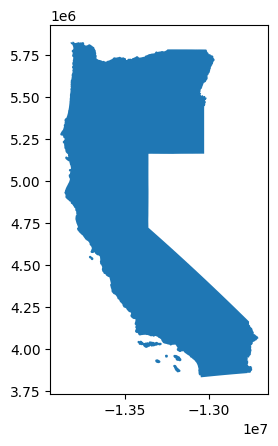

In [23]:
AOI_polygon_path = "F:\\Project_data2\\goes_data_false_alarm_cal\\shp\\poly.shp"
AOI = gpd.read_file(AOI_polygon_path)
AOI.plot() 

* Since we have for some of the GOES images Two VIIRS images we will merge them into one shapefile

In [24]:
## Create a df of GOES files that have more than one VIIRS file
GOES_files_more_than_one_VIIRS = matching_df[matching_df["GOES_file"].duplicated(keep=False)].reset_index(drop=True)
## Create a df of GOES files that have only one VIIRS file
GOES_files_one_VIIRS = matching_df[~matching_df["GOES_file"].duplicated(keep=False)].reset_index(drop=True)

* Now we will edit the GOES_more_than_one_VIIRS to assign each VIIRS file in a new column

In [25]:
## Create a df for GOES files where each VIIRS file gets his own column
GOES_VIIRS_more_than_one_pivot = (GOES_files_more_than_one_VIIRS.drop_duplicates() ## Drop duplicates
   .assign(col=lambda x: x.groupby("GOES_file").cumcount()) ## Create a column for each VIIRS file
   .pivot(index='GOES_file', columns='col', values='VIIRS_fire_file') ## Pivot the df
   .add_prefix('VIIRS_fire_file_').reset_index() ## Add prefix to the columns
)
GOES_VIIRS_more_than_one_pivot[:5]

col,GOES_file,VIIRS_fire_file_0,VIIRS_fire_file_1
0,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022182.0906.001.2022183034226.nc,VNP14IMG.A2022182.0912.001.2022183034226.nc
1,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022183.0848.001.2022183154402.nc,VNP14IMG.A2022183.0854.001.2022183154402.nc
2,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022183.2148.001.2022184064634.nc,VNP14IMG.A2022183.2154.001.2022184064634.nc
3,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022185.2112.001.2022186045831.nc,VNP14IMG.A2022185.2118.001.2022186045831.nc
4,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022186.0930.001.2022186175619.nc,VNP14IMG.A2022186.0936.001.2022186175619.nc


In [26]:
print(f"""the length of the df where GOES have more than one VIIRS file is
      {len(GOES_VIIRS_more_than_one_pivot)} and the length of the GOES that has only one is
      {len(GOES_files_one_VIIRS)} so in total it is files
      {len(GOES_VIIRS_more_than_one_pivot) + len(GOES_files_one_VIIRS)}
      which is exactly the same as the length of the unique matching_df {len(np.unique(matching_df["GOES_file"]))}""")

the length of the df where GOES have more than one VIIRS file is
      62 and the length of the GOES that has only one is
      477 so in total it is files
      539
      which is exactly the same as the length of the unique matching_df 539


# Now we can create a function the produce the footprint of VIIRS

In [27]:

def overlay_geodataframes(gdfs, how='union'):
    """
    Overlays a list of GeoDataFrames using the specified method.

    Parameters:
    - gdfs: list of GeoDataFrames to overlay
    - how: type of overlay to be performed (default is 'union') but can be any of the following:
        ['intersection', 'union', 'identity', 'symmetric_difference', 'difference']

    Returns:
    - A merged GeoDataFrame
    """
    return reduce(lambda left, right: gpd.overlay(left, right, how=how), gdfs)

# Example usage:
# gdf1, gdf2, gdf3 are your GeoDataFrames
# merged_gdf = overlay_geodataframes([gdf1, gdf2, gdf3], how='intersection')


In [28]:
def merge_VIIRS_polygons(VIIRS_paths_list, AOI_path, how="union"):
    """This function gets a list of VIIRS paths and returns a merged polygon

    Args:
        VIIIRS_paths_list (list): a list of VIIRS paths
        AOI_path (string): a full path to the AOI
        how (string): how to merge the polygons. for example "union" or "intersection"
    """
    
    VIIRS_polys = [GOES_VIIRS_tools.get_VIIRS_bounds_polygon(VIIRS) for VIIRS in VIIRS_paths_list] ## Create a list of polygons
    
    merged_df = overlay_geodataframes(VIIRS_polys, how=how) ## Merge the polygons
    if len(merged_df)>0: ## If the merged polygons are not empty
        merged_df["join"] = 1 ## Create a join column
        merged_df = merged_df.dissolve("join") ## Dissolve the polygons
        AOI = gpd.read_file(AOI_path) ## Read the AOI
        AOI = AOI.to_crs(merged_df.crs) ## Set the AOI to the same crs as the merged polygons
    
        ## check if the merged polygons are in the AOI
        con = AOI.unary_union.intersects(merged_df.unary_union) ## Check if the polygons are in the AOI
        if con == True: ## If the polygons are in the AOI
            return(merged_df) ## Return the merged polygons
        if con == False: ## If the polygons are not in the AOI
            return(False) ## Return False
        
    else: ## If the merged polygons are empty
        return(False) ## Return False
    

In [29]:
def crop_GOES_with_several_VIIRS_poly(GOES_file_path, VIIRS_paths_list, GOES_CRS, AOI_path, how="union"):
    """this function create a croped GOES image from two VIIRS polygons

    Args:
        GOES_file_path (path string): GOES_path
        VIIRS_paths_list (list): list of VIIRS paths
        GOES_CRS: CRS of GOES MCMI image
        AOI_path: full path for AOI of california
        how (string): how to merge the polygons. for example "union" or "intersection"
    """
     ## Open data
    CRS = GOES_CRS
    merged_poly = merge_VIIRS_polygons(VIIRS_paths_list=VIIRS_paths_list, AOI_path=AOI_path, how=how)
    if  isinstance(merged_poly,gpd.GeoDataFrame): ## If the merged polygons are not empty
        GOES = rioxarray.open_rasterio(GOES_file_path)
        ## set CRS for GOES image and the polygon
        GOES = GOES.rio.set_crs(CRS)
        merged_poly = merged_poly.to_crs(CRS)
        if np.any(merged_poly.get_coordinates()[["x"]] == float("inf")): ## check for bugs in the convertion
            return("There is a bug in the convertion")
        else:
            ## Clip
            GOES_clip = GOES.rio.clip(merged_poly["geometry"])
            ## Convert -99 to nan
            con = GOES_clip.values[0] == -99
            GOES_clip.values[0][con] = np.nan
            return(GOES_clip)
    else: ## If the merged polygons are empty
        return("AOI and VIIRS footprint wont intersect")
        

# a function to crop only one GOES file to the VIIRS footprint

In [51]:
## Same function as before but this time to see if there is any intersection
def clip_GOES_to_VIIRS_bounds_intersect(GOES_path, VIIRS_image_path, GOES_CRS, AOI_path):
    """
    Get a VIIRS fire product path and a GOES fire product path and CRS and return a cliped GOES image
    
    :GOES_path: GOES fire product for example "F:\\Project_data2\\goes_data_false_alarm_cal\\fire_product_out\\2022_01_09_00_02.tif"
    :VIIRS_image_path: VIIRS fire product for example "C:\\Asaf\\VIIRS\\VNP14IMG.A2020251.2042.001.2020258064138"
    :GOES_CRS: GOES CRS code that can be extracted from an MCMI file
    :AOI_path: Full AOI path
    
    :return: a clipped GOES fire product image
    """ 
    ## Open data
    CRS = GOES_CRS
    VIIRS_bounds_polygon = GOES_VIIRS_tools.get_VIIRS_bounds_polygon(VIIRS_fire_path=VIIRS_image_path)
    VIIRS_bounds_polygon = VIIRS_bounds_polygon.to_crs(CRS)
    if np.any(VIIRS_bounds_polygon.get_coordinates()[["x"]] == float("inf")): ## if there is a bug in the convertion
        return("There is a bug in the convertion")
    else:
        GOES = rioxarray.open_rasterio(GOES_path)
        AOI = gpd.read_file(AOI_path) ## Open AOI and convert to GOES CRS
        AOI = AOI.to_crs(CRS)
        ## set CRS for GOES image and the polygon
        GOES = GOES.rio.set_crs(CRS)
        con_geo = VIIRS_bounds_polygon.intersects(AOI) ## If there is not any intersecton return a string
        if con_geo[0] == False: ## If there is no intersection
            return("There is no geo match") ## Return a string
        else: ## if there is an intersection:
        ## Clip
            GOES_clip = GOES.rio.clip(VIIRS_bounds_polygon["geometry"]) ## Clip the GOES image
        ## Convert -99 to nan
            con = GOES_clip.values[0] == -99 ## Convert -99 to nan
            GOES_clip.values[0][con] = np.nan ## Convert -99 to nan
            return(GOES_clip) ## Return the clipped GOES image

* Here is an example of the function

In [30]:
V1 = f"{VIIRS_path}\\{GOES_VIIRS_more_than_one_pivot['VIIRS_fire_file_0'][0]}"
V2 = f"{VIIRS_path}\\{GOES_VIIRS_more_than_one_pivot['VIIRS_fire_file_0'][1]}"
V3 = f"{VIIRS_path}\\{GOES_VIIRS_more_than_one_pivot['VIIRS_fire_file_0'][2]}"

In [31]:
V1_poly = GOES_VIIRS_tools.get_VIIRS_bounds_polygon(V1)
V2_poly = GOES_VIIRS_tools.get_VIIRS_bounds_polygon(V2)
V3_poly = GOES_VIIRS_tools.get_VIIRS_bounds_polygon(V3)
AOI_copy = AOI.copy()
AOI_copy = AOI_copy.to_crs(V1_poly.crs)

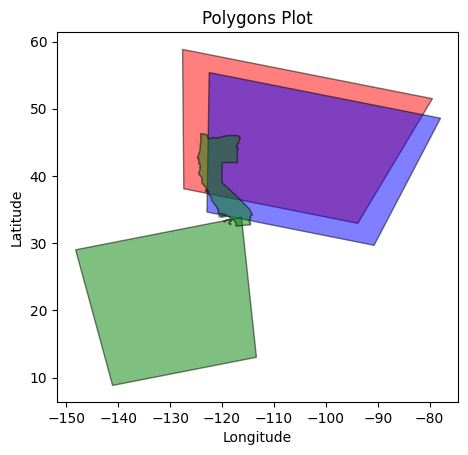

In [32]:
# Create a plot
fig, ax = plt.subplots()

# Plot each GeoDataFrame with different colors
V1_poly.plot(ax=ax, color='red', edgecolor='black', alpha=0.5)
V2_poly.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5)
V3_poly.plot(ax=ax, color='green', edgecolor='black', alpha=0.5)
AOI_copy.plot(ax=ax, color='green', edgecolor='black', alpha=0.5)

# Set plot title and labels
ax.set_title('Polygons Plot')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [33]:
## Merge the VIIRS polygons
out_put_example = merge_VIIRS_polygons(VIIRS_paths_list=[V1, V2, V3],
                                       AOI_path=AOI_polygon_path, how="union")

C:\Users\asaf_rs\AppData\Local\Temp\ipykernel_9368\3797050985.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  con = AOI.unary_union.intersects(merged_df.unary_union) ## Check if the polygons are in the AOI


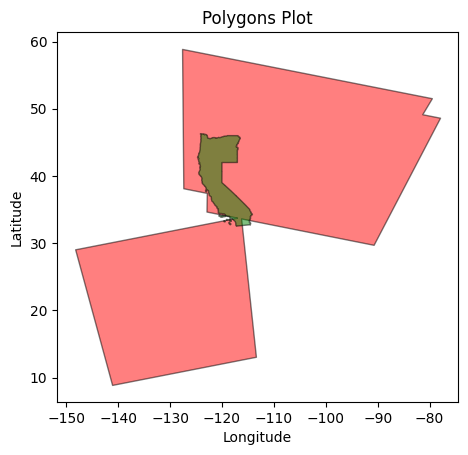

In [34]:
# Create a plot
fig, ax = plt.subplots()

# Plot each GeoDataFrame with different colors
out_put_example.plot(ax=ax, color='red', edgecolor='black', alpha=0.5)
AOI_copy.plot(ax=ax, color='green', edgecolor='black', alpha=0.5)

# Set plot title and labels
ax.set_title('Polygons Plot')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

# Now we can start croping the GOES images to the VIIRS footprint

In [ ]:
## Clip GOES files that have more than one VIIRS file
GOES_out_path = "F:\\out_goes"
for i in range(len(GOES_VIIRS_more_than_one_pivot)): ## Loop through the GOES files
    goes_fp = GOES_VIIRS_more_than_one_pivot["GOES_file"].iloc[i] ## GOES file path
    f_name = goes_fp.split("\\")[-1] ## take file date
    ## Create a list of VIIRS files
    VIIRS_list = [f"{VIIRS_path}\\{VIIRS}" for VIIRS in GOES_VIIRS_more_than_one_pivot.iloc[i][1:]] ## VIIRS list
    ## Clip the GOES file
    clipped_GOES = crop_GOES_with_several_VIIRS_poly(GOES_file_path=goes_fp, VIIRS_paths_list=VIIRS_list,
                                                     GOES_CRS=GOES_CRS, AOI_path=AOI_polygon_path, how="union") 
    full_f_name = "{}\\{}".format(GOES_out_path, f_name) ## Full path
    clipped_GOES.rio.to_raster(full_f_name) ## Save the clipped GOES file
    print("{} is done".format(f_name)) ## Print the file name

# Now we will clip the GOES files that have only one VIIRS file

In [52]:
## Clip GOES files that have one VIIRS file
for i in range(len(GOES_files_one_VIIRS)): ## Loop through the GOES files
    goes_fp = GOES_files_one_VIIRS["GOES_file"].iloc[i]## GOES file path
    f_name = goes_fp.split("\\")[-1] ## take file date
    VIIRS_file = "{}\\{}".format(VIIRS_path, GOES_files_one_VIIRS["VIIRS_fire_file"].iloc[i]) ## VIIRS file path
    ## Clip the GOES file
    clipped_GOES = clip_GOES_to_VIIRS_bounds_intersect(GOES_path=goes_fp, VIIRS_image_path=VIIRS_file,
                                                       GOES_CRS=GOES_CRS, AOI_path=AOI_polygon_path)
    full_f_name = "{}\\{}".format(GOES_out_path, f_name)## Full path
    clipped_GOES.rio.to_raster(full_f_name)## Save the clipped GOES file
    print("{} is done".format(f_name))## Print the file name

2022_07_01_09_02.tif is done
2022_07_01_09_12.tif is done
2022_07_01_09_17.tif is done
2022_07_01_10_47.tif is done
2022_07_01_10_52.tif is done
2022_07_01_20_27.tif is done
2022_07_01_20_32.tif is done
2022_07_01_22_07.tif is done
2022_07_01_22_12.tif is done
2022_07_01_22_17.tif is done
2022_07_02_08_47.tif is done
2022_07_02_08_57.tif is done
2022_07_02_10_27.tif is done
2022_07_02_10_32.tif is done
2022_07_02_20_07.tif is done
2022_07_02_20_12.tif is done
2022_07_02_20_17.tif is done
2022_07_02_21_47.tif is done
2022_07_02_21_57.tif is done
2022_07_03_08_27.tif is done
2022_07_03_08_32.tif is done
2022_07_03_10_07.tif is done
2022_07_03_10_12.tif is done
2022_07_03_10_17.tif is done
2022_07_03_19_52.tif is done
2022_07_03_19_57.tif is done
2022_07_03_21_32.tif is done
2022_07_03_21_37.tif is done
2022_07_04_09_52.tif is done
2022_07_04_09_57.tif is done
2022_07_04_21_07.tif is done
2022_07_04_21_12.tif is done
2022_07_04_21_22.tif is done
2022_07_05_09_27.tif is done
2022_07_05_09_

# Now we will do the same process for for the matching GOES and VIIRS files that are not in the shapefile

In [37]:
## Create a df of GOES files that have more than one VIIRS file
GOES_files_more_than_one_VIIRS_not_in_shapefile = GOES_VIIRS_matching_df_not_in_shapefile[GOES_VIIRS_matching_df_not_in_shapefile["GOES_file"].duplicated(keep=False)].reset_index(drop=True)
## Create a df of GOES files that have only one VIIRS file
GOES_files_one_VIIRS_not_in_shapefile = GOES_VIIRS_matching_df_not_in_shapefile[~GOES_VIIRS_matching_df_not_in_shapefile["GOES_file"].duplicated(keep=False)].reset_index(drop=True)

In [38]:
## Create a df for GOES files where each VIIRS file gets his own column
GOES_VIIRS_more_than_one_notinshp_pivot = (GOES_files_more_than_one_VIIRS_not_in_shapefile.drop_duplicates() ## Drop duplicates
   .assign(col=lambda x: x.groupby("GOES_file").cumcount()) ## Create a column for each VIIRS file
   .pivot(index='GOES_file', columns='col', values='VIIRS_fire_file') ## Pivot the df
   .add_prefix('VIIRS_fire_file_').reset_index() ## Add prefix to the columns
)
GOES_VIIRS_more_than_one_notinshp_pivot[:5]

col,GOES_file,VIIRS_fire_file_0,VIIRS_fire_file_1
0,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022185.0806.001.2022185155026.nc,VNP14IMG.A2022185.0812.001.2022185155026.nc
1,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022185.1930.001.2022186032546.nc,VNP14IMG.A2022185.1936.001.2022186032546.nc
2,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022186.1112.001.2022186183819.nc,VNP14IMG.A2022186.1118.001.2022186183819.nc
3,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022187.2218.001.2022188053018.nc,VNP14IMG.A2022187.2224.001.2022188053018.nc
4,F:\Project_data2\goes_data_false_alarm_cal\fir...,VNP14IMG.A2022192.2224.001.2022193054051.nc,VNP14IMG.A2022192.2230.001.2022193054051.nc


In [39]:
print(f"""the length of the df where GOES have more than one VIIRS file is
      {len(GOES_VIIRS_more_than_one_notinshp_pivot)} and the length of the GOES that has only one is
      {len(GOES_files_one_VIIRS_not_in_shapefile)} so in total it is files
      {len(GOES_VIIRS_more_than_one_notinshp_pivot) + len(GOES_files_one_VIIRS_not_in_shapefile)}
      which is exactly the same as the length of the unique matching_df {len(np.unique(GOES_VIIRS_matching_df_not_in_shapefile["GOES_file"]))}""")

the length of the df where GOES have more than one VIIRS file is
      27 and the length of the GOES that has only one is
      387 so in total it is files
      414
      which is exactly the same as the length of the unique matching_df 414


In [ ]:
## Clip GOES files that have more than one VIIRS file not in shapefile
GOES_out_path_not_in_shp = "F:\\out_goes_notinshp"
for i in range(len(GOES_VIIRS_more_than_one_notinshp_pivot)): ## Loop through the GOES files
    goes_fp = GOES_VIIRS_more_than_one_notinshp_pivot["GOES_file"].iloc[i] ## GOES file path
    f_name = goes_fp.split("\\")[-1] ## take file date
    ## Create a list of VIIRS files
    VIIRS_list = [f"{VIIRS_path}\\{VIIRS}" for VIIRS in GOES_VIIRS_more_than_one_notinshp_pivot.iloc[i][1:]] ## VIIRS list
    ## Clip the GOES file
    clipped_GOES = crop_GOES_with_several_VIIRS_poly(GOES_file_path=goes_fp, VIIRS_paths_list=VIIRS_list,
                                                     GOES_CRS=GOES_CRS, AOI_path=AOI_polygon_path, how="union") 
    if not isinstance(clipped_GOES, str): ## If the output is not a string
        full_f_name = "{}\\{}".format(GOES_out_path_not_in_shp, f_name) ## Full path
        clipped_GOES.rio.to_raster(full_f_name) ## Save the clipped GOES file
        print("{} is done".format(f_name)) ## Print the file name
    else:
        print(f_name, clipped_GOES)

# And now we will do it for GOES files that match one VIIRS file not in the shapefile

In [55]:
## Clip GOES files that have one VIIRS file not in shapefile
for i in range(len(GOES_files_one_VIIRS_not_in_shapefile)): ## Loop through the GOES files
    goes_fp = GOES_files_one_VIIRS_not_in_shapefile["GOES_file"].iloc[i] ## GOES file path
    f_name = goes_fp.split("\\")[-1] ## take file name
    ## Create VIIRS file path
    VIIRS_file = "{}\\{}".format(VIIRS_path, GOES_files_one_VIIRS_not_in_shapefile["VIIRS_fire_file"].iloc[i])
    ## Clip the GOES file
    clipped_GOES = clip_GOES_to_VIIRS_bounds_intersect(GOES_path=goes_fp, VIIRS_image_path=VIIRS_file,
                                                       GOES_CRS=GOES_CRS, AOI_path=AOI_polygon_path)
    if not isinstance(clipped_GOES, str):  ## If the output is not a string
    ## Save the clipped GOES file
        full_f_name = "{}\\{}".format(GOES_out_path_not_in_shp, f_name)
        clipped_GOES.rio.to_raster(full_f_name) ## Save the clipped GOES file
        print("{} is done".format(f_name)) ## Print the file name
    else:
        print(f_name, clipped_GOES)

2022_07_01_10_57.tif There is no geo match
2022_07_01_18_52.tif There is a bug in the convertion
2022_07_01_18_57.tif There is a bug in the convertion
2022_07_01_20_37.tif is done
2022_07_01_22_22.tif There is no geo match
2022_07_02_10_37.tif There is no geo match
2022_07_02_12_02.tif There is no geo match
2022_07_02_12_07.tif There is no geo match
2022_07_02_18_32.tif There is a bug in the convertion
2022_07_02_18_37.tif There is a bug in the convertion
2022_07_03_08_22.tif There is a bug in the convertion
2022_07_03_10_02.tif is done
2022_07_03_11_47.tif There is no geo match
2022_07_03_11_52.tif There is no geo match
2022_07_03_19_47.tif There is no geo match
2022_07_03_21_27.tif is done
2022_07_04_08_02.tif There is a bug in the convertion
2022_07_04_08_12.tif is done
2022_07_04_08_17.tif is done
2022_07_04_09_47.tif is done
2022_07_04_11_27.tif is done
2022_07_04_11_32.tif is done
2022_07_04_19_27.tif is done
2022_07_04_19_37.tif is done
2022_07_05_11_07.tif is done
2022_07_05_11